In [2]:
import torch

# Check PyTorch version
print(f"PyTorch version: {torch.__version__}")

# Check CUDA version
print(f"CUDA version: {torch.version.cuda}")

# Check if CUDA is

PyTorch version: 2.3.1+cu121
CUDA version: 12.1


In [3]:
import torch
import torch.nn.functional as F
import torch_geometric
from torch_geometric.datasets import TUDataset
from torch_geometric.data import DataLoader
from sklearn.model_selection import train_test_split

Importing the dataset

In [4]:
#imoporting the protein dataset
dataset = TUDataset(root='data/TUDataset', name='PROTEINS')

print(f'Dataset: {dataset}:')
print('======================')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')

dataset = dataset.shuffle()

Dataset: PROTEINS(1113):
Number of graphs: 1113
Number of features: 3
Number of classes: 2


In [5]:
# Gather some statistics about the first graph.

data = dataset[0]  # Get the first graph object.

print(data)
print(f'Number of nodes: {data.num_nodes}')
print(f'Number of edges: {data.num_edges}')
print(f'Average node degree: {data.num_edges / data.num_nodes:.2f}')
print(f'Number of features per node: {data.num_node_features}')
print(f'Number of features per edge: {data.num_edge_features}')
print(f'Number of class label: {data.y}')

classes = ['non-enyzme', 'enzyme']


Data(edge_index=[2, 348], x=[93, 3], y=[1])
Number of nodes: 93
Number of edges: 348
Average node degree: 3.74
Number of features per node: 3
Number of features per edge: 0
Number of class label: tensor([0])


Visualizing samples

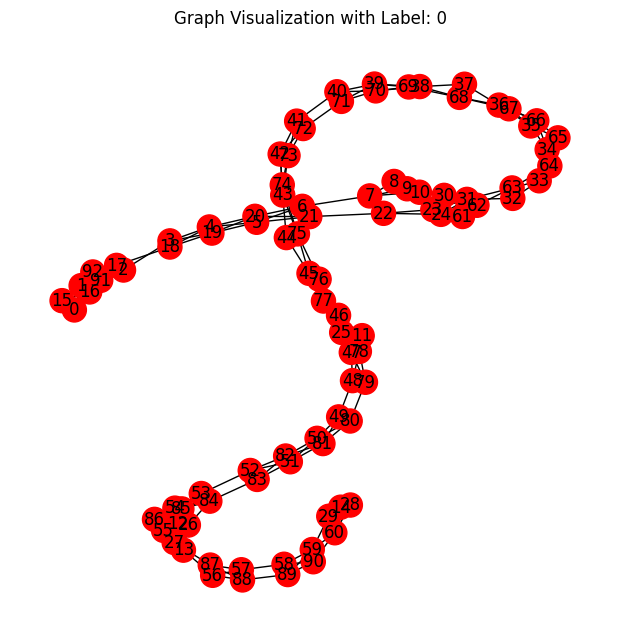

In [10]:
#visualizing a sample graph
from torch_geometric.utils import to_networkx
import networkx as nx
import matplotlib.pyplot as plt

data = dataset[0]
G = to_networkx(data, to_undirected=True)


# Determine the color map or labels based on data.y (assuming it's the graph label)
graph_label = data.y.item()  # Assuming data.y is a single-element tensor
colors = ['red' if data.y.item() == 0 else 'blue' for _ in range(data.num_nodes)]  # Example: Assign colors based on the graph label

# Plotting the graph
plt.figure(figsize=(6, 6))
nx.draw(G, with_labels=True, node_color=colors, cmap="Set2")
plt.title(f'Graph Visualization with Label: {graph_label}')
plt.show()

In [11]:
#splitting the dataset into training and testing
train_dataset, test_dataset = train_test_split(dataset, test_size=0.2)

#creating dataloaders
BATCH_SIZE = 32
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

print(f'Number of training graphs: {len(train_dataset)}')
print(f'Number of test graphs: {len(test_dataset)}')

Number of training graphs: 890
Number of test graphs: 223


In [12]:
#device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

Graph Neural Network Model

In [13]:
from torch_geometric.nn import GCNConv
from torch_geometric.nn import global_mean_pool


class GCN(torch.nn.Module):
    def __init__(self, hidden_channels_1, hidden_channels_2, hidden_channels_3, hidden_channels_4):
        """Graph Convolutional Network with 3 layers following by a post message passing layer"""

        super(GCN, self).__init__()
        torch.manual_seed(12345)
        self.conv1 = GCNConv(dataset.num_node_features, hidden_channels_1)
        self.conv2 = GCNConv(hidden_channels_1, hidden_channels_2)
        self.conv3 = GCNConv(hidden_channels_2, hidden_channels_3)

        #post message passing layers
        self.post_mp = torch.nn.Sequential(
            torch.nn.Linear(hidden_channels_3, hidden_channels_4),
            torch.nn.Dropout(0.2),
            torch.nn.Linear(hidden_channels_4, dataset.num_classes)
        )

    def forward(self, x, edge_index, batch):
        # First layer
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = F.dropout(x, p=0.2, training=self.training)

        # Second layer
        x = self.conv2(x, edge_index)
        x = x.relu()
        x = F.dropout(x, p=0.25, training=self.training)

        # Third layer
        x = self.conv3(x, edge_index)
        x = F.dropout(x, p=0.5, training=self.training)
        
        # Global pooling
        x = global_mean_pool(x, batch)

        # Post message passing
        x = self.post_mp(x)
        embedding = x

        # Return the final output (logits)
        x = F.log_softmax(x, dim=1)

        return x, embedding

Setting up the model

In [14]:
#setting the model
torch.manual_seed(42)
torch.cuda.manual_seed(42)

model = GCN(32,64,64,32).to(device)
model

GCN(
  (conv1): GCNConv(3, 32)
  (conv2): GCNConv(32, 64)
  (conv3): GCNConv(64, 64)
  (post_mp): Sequential(
    (0): Linear(in_features=64, out_features=32, bias=True)
    (1): Dropout(p=0.2, inplace=False)
    (2): Linear(in_features=32, out_features=2, bias=True)
  )
)

In [15]:
#loss function and optimizer

loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=8e-5, weight_decay = 1e-4)

Evaluation Metrics

Training and testing functions

In [16]:
def train_step(model, data_loader, loss_fn, optimizer):
    """training the model for one epoch"""

    model.train()
    
    train_loss, train_accuracy = 0, 0

    for data in data_loader:
        data = data.to(device)
        optimizer.zero_grad()
        output, _ = model(data.x, data.edge_index, data.batch)
        loss = loss_fn(output, data.y)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

        #accuracy
        train_accuracy += (output.argmax(dim=1) == data.y).sum().item()

    train_loss /= len(data_loader.dataset)
    train_accuracy /= len(data_loader.dataset)

    return train_loss, train_accuracy

In [17]:
def test_step(model, data_loader, loss_fn):
    """testing the model for one epoch"""

    model.eval()

    test_loss, test_accuracy = 0, 0

    for data in data_loader:
        data = data.to(device)
        output, _ = model(data.x, data.edge_index, data.batch)
        loss = loss_fn(output, data.y)

        test_loss += loss.item()
        test_accuracy += (output.argmax(dim=1) == data.y).sum().item()

    test_loss /= len(data_loader.dataset)
    test_accuracy /= len(data_loader.dataset)

    return test_loss, test_accuracy

In [18]:
def train(model:torch.nn.Module, 
            train_loader:DataLoader, 
            test_loader:DataLoader, 
            loss_fn:torch.nn.Module, 
            optimizer:torch.optim.Optimizer, 
            epochs:int,
            model_out_path:str):
    """training the model"""

    #Create empty results dictionary
    results = {
        "train_loss": [],
        "train_accuracy": [],
        "test_loss": [],
        "test_accuracy": []
    }

    for epoch in range(epochs):
        train_loss, train_accuracy = train_step(model, train_loader, loss_fn, optimizer)
        test_loss, test_accuracy = test_step(model, test_loader, loss_fn)

        results["train_loss"].append(train_loss)
        results["train_accuracy"].append(train_accuracy)
        results["test_loss"].append(test_loss)
        results["test_accuracy"].append(test_accuracy)

        print(f'Epoch: {epoch+1:03d}, Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}')
        if (epoch+1) % 25 == 0:
            out_path = f'{model_out_path}/gcn_model_{epoch+1}.pt'
            model_cpu = model.to("cpu")
            torch.save(model_cpu.state_dict(), out_path)
            model = model.to(device)

    return results

GCN Training

In [86]:
#set the random seed
torch.manual_seed(12345)
torch.cuda.manual_seed(12345)

#set timer
import time
start_time = time.time()

model_out_path = 'models'

#train the model
results = train(model,
                train_loader,
                test_loader,
                loss_fn,
                optimizer,
                epochs=200,
                model_out_path=model_out_path) 

Epoch: 001, Train Loss: 0.0212, Train Accuracy: 0.5978, Test Loss: 0.0213, Test Accuracy: 0.5874
Epoch: 002, Train Loss: 0.0212, Train Accuracy: 0.5978, Test Loss: 0.0212, Test Accuracy: 0.5874
Epoch: 003, Train Loss: 0.0212, Train Accuracy: 0.5978, Test Loss: 0.0212, Test Accuracy: 0.5874
Epoch: 004, Train Loss: 0.0212, Train Accuracy: 0.5978, Test Loss: 0.0212, Test Accuracy: 0.5874
Epoch: 005, Train Loss: 0.0212, Train Accuracy: 0.5978, Test Loss: 0.0212, Test Accuracy: 0.5874
Epoch: 006, Train Loss: 0.0211, Train Accuracy: 0.5978, Test Loss: 0.0212, Test Accuracy: 0.5874
Epoch: 007, Train Loss: 0.0212, Train Accuracy: 0.5978, Test Loss: 0.0212, Test Accuracy: 0.5874
Epoch: 008, Train Loss: 0.0211, Train Accuracy: 0.5978, Test Loss: 0.0212, Test Accuracy: 0.5874
Epoch: 009, Train Loss: 0.0211, Train Accuracy: 0.5978, Test Loss: 0.0212, Test Accuracy: 0.5874
Epoch: 010, Train Loss: 0.0211, Train Accuracy: 0.5978, Test Loss: 0.0211, Test Accuracy: 0.5874
Epoch: 011, Train Loss: 0.0210

Plot loss curves

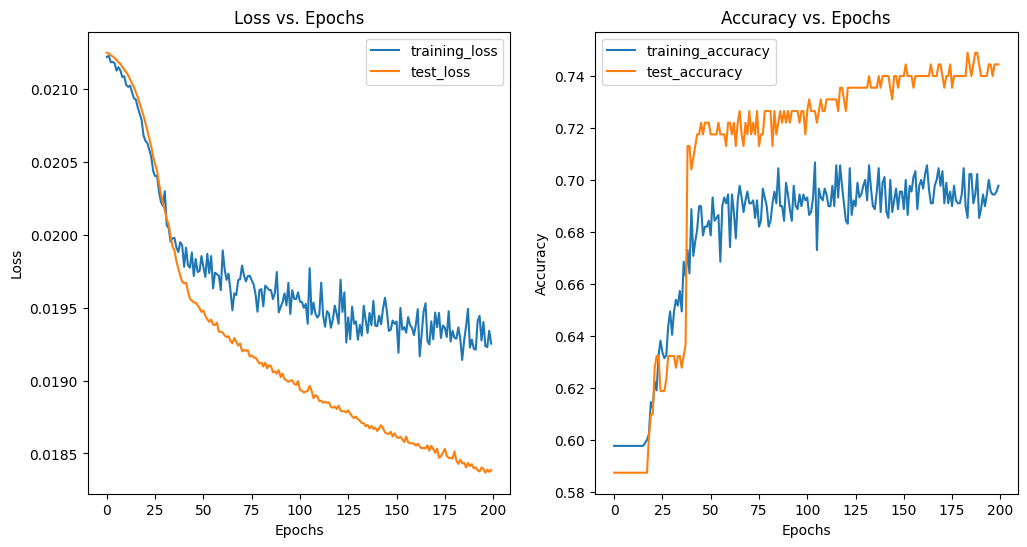

In [88]:
import torch
import matplotlib.pyplot as plt

def plot_loss_curves(results):
    """
    Plots the loss curves of the training and test datasets.
    """
    loss = results["train_loss"]
    test_loss = results["test_loss"]
    accuracy = torch.tensor(results["train_accuracy"]).cpu()  # Convert to tensor and move to CPU
    test_accuracy = torch.tensor(results["test_accuracy"]).cpu()  # Convert to tensor and move to CPU
    
    epochs = range(len(results["train_loss"]))

    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, label="training_loss")
    plt.plot(epochs, test_loss, label="test_loss")
    plt.title("Loss vs. Epochs")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracy, label="training_accuracy")
    plt.plot(epochs, test_accuracy, label="test_accuracy")
    plt.title("Accuracy vs. Epochs")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend()

    plt.show()

plot_loss_curves(results)

Save the final model

In [91]:
#save the model
model.to("cpu")
model_out_path = 'final_protein_gcn_model.pt'
torch.save(model.state_dict(), model_out_path)

Evaluating the model on test set

In [96]:
#evaluating the model performance on test dataset

def accuracy_score(y_true, y_pred):
    """Computes the accuracy score"""
    return sum(y_i == y_j for y_i, y_j in zip(y_true, y_pred)) / len(y_true)

def precision_score(y_true, y_pred):
    """Computes the precision score"""
    true_positive = sum(y_i == y_j == 1 for y_i, y_j in zip(y_true, y_pred))
    predicted_positive = sum(y_i == 1 for y_i in y_pred)
    return true_positive / predicted_positive

def recall_score(y_true, y_pred):
    """Computes the recall score"""
    true_positive = sum(y_i == y_j == 1 for y_i, y_j in zip(y_true, y_pred))
    actual_positive = sum(y_i == 1 for y_i in y_true)
    return true_positive / actual_positive

def f1_score(y_true, y_pred):
    """Computes the F1 score"""
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    return 2 * (precision * recall) / (precision + recall)

def evaluation_metrics(model, data_loader):
    """Evaluates the model on the test dataset"""

    model.eval()

    y_true = []
    y_pred = []

    for data in data_loader:
        data = data
        output, _ = model(data.x, data.edge_index, data.batch)

        y_true += data.y.tolist()
        y_pred += output.argmax(dim=1).tolist()

    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)

    return accuracy, precision, recall, f1

In [97]:
#evaluating the model

accuracy, precision, recall, f1 = evaluation_metrics(model, test_loader)

print(f'Accuracy: {accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')

Accuracy: 0.7444
Precision: 0.7692
Recall: 0.5435
F1 Score: 0.6369
